# Earth Observation Stack constructor class
The class eoTempStack reads the resulting products of the pre-processed Sentinel-1, Sentinel-2 and Landsat (7/8) images. The pre-processing script results in a defined directory structure with is hard coded in the class methods. The class has the necessary methods to calculate two vegetation indices from the available optical images.

In [137]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 17 15:32:31 2018

@author: asalazar
"""

import rasterio, os, re, datetime
import numpy as np
import pandas as pd
import xarray as xr

#from rasterio.rio import stack

class eoTempStack(object):
    """
    Class to construct and analyze a multi temporal stack of earth observation images. Supports Sentinel-1, Sentinel-2,
    Landsat 7 and Landsat 8 pre-processed products. All images in the same object have the same coordinate system, spatial
    extent and resolution. Operates on a dictionary of band names for each of the supported products. Required pre-processing:
        - For Sentinel-1... 
        - For Sentinel-2... L2A
        - For Landsat(7/8)...
    """
    def __init__(self, sourcedir, outdir, prodtype):
        """
        Class constructor.
        
        @sourcedir (str): location of products as described in @prodtype
        @outdir (str): directory to store resulting data products (raster stack)
        @prodtype (str): accepts 'S1', 'S2', 'L7', 'L8' where
                            'S1': set of .img files with the same extent and polarization, product from SNAP collocation Op
                            'S2': set of directories resulting from sen2cor processing Sentinel-2 level 2A product
        """        
        ##toDO assert that sourcedir finished in slash 
        self.source_directory = sourcedir
        self.prod_type = prodtype
        self.out_directory = outdir
        self.bands_loc = {} #Declare dictionary. Set in setBandsLoc
        self.bands_temporal_range = {} #Declare dictionary. Set in setTempData
        #self.tif_stack_location = {} #Declare dictionary. Set in setStackLoc
        
        # Set the minimum required variables to construct the object. Implementation varies by product (subclass).
        self.setBandsLoc()
        #self.setStackLoc()
        self.setTempData()
        
        #buildAllStack implements temporal stacking of each band as GeoTIFF. Currently not used.
        #self.buildAllStack()
           
        print('{} object initialized from {}'.format(self.prod_type, self.source_directory))
        
    def getBandsLoc(self, band=None):
        if band is not None:
            return self.bands_loc[band]
        else:
            return self.bands_loc
    
    def getTempData(self, band=None):
        if band is not None:
            return self.bands_temporal_range[band]
        else:
            return self.bands_temporal_range
    
    def getSourceDir(self):
        return self.source_directory
    
    def getBand(self, band, tempid=None, date=None):
        """Operates on all bands in object unless an tempid or date is provided.
        Returns a band or a list of bands"""
        bandsloc = self.getBandsLoc(band)
        if tempid is not None:
            with rasterio.open(bandsloc[tempid]) as src:
                readband = src.read(1)
        elif date is not None:
            with rasterio.open(bandsloc[self.getBandIndex(date)]) as src:
                readband = src.read(1)
        else:
            readband = []
            for loc in bandsloc:
                with rasterio.open(loc) as src:
                    readband.append(src.read(1))
        return readband
    
    def getBandIndex(self, date):
        """Return the tempid in of the date in the  
        define if date is a string or a date type
        """
        for id, layer in enumerate(self.getTempData().itervalues().next()):
            if date == layer:
                return id
    
    def getBandXarray(self, band):
        """Returns an xarray object from all dates in a given band"""
        time = xr.Variable('time', pd.DatetimeIndex([pd.Timestamp(f) for f in self.getTempData(band)]))
        arlist = [xr.open_rasterio(f) for f in self.getBandsLoc(band)]
        da = xr.concat(arlist, dim=time)
        return da
    
class S1TempStack(eoTempStack):
    bands_of_interest = ['VV', 'VH']
    
    def __init__(self, sourcedir, outdir):
        # Call eo_tempstack initialization method
        super(S1TempStack, self).__init__(sourcedir, outdir, 'S1')
    
    def setBandsLoc(self):
        ## Get directory names of pre-processed S1 GRD products to process
        proddirs = filter(re.compile(r'S1.*data$').search, os.listdir(self.source_directory))
        
        ## Declare dictionary to store file location by polarizations
        prodlist = {}
        for prod_dir in proddirs:
            # List and filter img files for Sigma0 bands, store full path to file
            image_files = filter(re.compile(r'Sigma0.*img$').search, os.listdir(self.source_directory+prod_dir))
            prodlist[prod_dir.split('_')[1]] = list(map(lambda x: self.getSourceDir()+prod_dir+'/'+x, image_files))
        # Store the dictionary of files location as instance variable
        self.bands_loc = prodlist
        
    def setTempData(self, key=None, tempdata=None):
        #if key is not None and tempdata is not None:
        #    self.bands_temporal_range[key] = tempdata
        #else:
        ## Declare dictionary to store dates by polarization
        temp_range = {}
        for key, value in self.getBandsLoc().iteritems():
            temp_range[key] = list(map(lambda x: datetime.datetime.strptime(x.split('/')[-1].split('_')[3],'%d%b%Y').date(), value))
            # Store dictionary as instance variable
        self.bands_temporal_range = temp_range
    
    def getXarray(self):
        xarrays = []
        for band in self.bands_of_interest:
            x = self.getBandXarray(band).isel(band=0)
            xarrays.append(x)
        ## Modify this to match standard_band_dict
        band = xr.Variable('band', pd.Index(self.bands_of_interest))
        da = xr.concat(xarrays, band)
        return da
    
    def getXDataset(self):
        xarrays = []
        for band in self.bands_of_interest:
            x = self.getBandXarray(band).isel(band=0)
            x.name = band
            xarrays.append(x)
        ## Modify this to match standard_band_dict
        ## band = xr.Variable('band', pd.Index(self.bands_of_interest))
        da = xr.merge(xarrays)#xr.concat(xarrays, band)
        return da
    
class S2TempStack(eoTempStack):
    cloud_quality_limit = {'quality_cloud_confidence':9,'quality_scene_classification':3}     #quality_cloud_confidence>9,
                                                                                            #quality_scene_classification == 3
    bands_of_interest = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'quality_cloud_confidence','quality_scene_classification']
    
    standard_band_dict = {'B2':'blue', 'B3':'green', 'B4':'red', 'B8':'nir', 'B11':'swir1', 'B12':'swir2', 
                          'quality_cloud_confidence':'CloudQA1','quality_scene_classification':'CloudQA2'}
    calculated_bands = ['NDVI', 'LSWI'] 
    
    ## Init method to include indices calculation
    def __init__(self, sourcedir, outdir):
        # Call eo_tempstack initialization method
        super(S2TempStack, self).__init__(sourcedir, outdir, 'S2')
        # Calculate indices at initialization
        for band in self.calculated_bands: self.calcIndex(band)
        
    def setBandsLoc(self, key=None, bandloc=None):
        if key is not None and bandloc is not None:
            self.bands_loc[key] = bandloc
        else:
            ## Get names of files to stack in raster
            prodlist = filter(re.compile(r'^S2.*data$').search, os.listdir(self.getSourceDir()))
            prodloclist = {}
            for band in self.bands_of_interest:
                prodloclist[band] = list(map(lambda x: self.getSourceDir()+x+'/'+band+'.img', prodlist))
            self.bands_loc = prodloclist
        
    def setTempData(self, key=None, tempdata=None):
        if key is not None and tempdata is not None:
            self.bands_temporal_range[key] = tempdata
        else:
            temp_range = {}
            for key, value in self.getBandsLoc().iteritems():
                temp_range[key] = list(map(lambda x: datetime.datetime.strptime(x.split('/')[-2][11:19], 
                                                                                '%Y%m%d').date(),value))
            self.bands_temporal_range = temp_range
        
    def calcQualityPixels(self):
        """Calculates cloud cover and shade by date from original Sentinel-2 files"""
        qualitypixels = []
        for date in self.getTempData('quality_cloud_confidence'):
            cloud_mask = self.getBand('quality_cloud_confidence', date=date) > self.cloud_quality_limit['quality_cloud_confidence']
            shadow_mask = self.getBand('quality_scene_classification', date=date) == self.cloud_quality_limit['quality_scene_classification']
            rmask = np.logical_or(cloud_mask, shadow_mask)
            qualitypixels.append(1 - float(np.sum(rmask)) / float(rmask.size))
        return qualitypixels
        
    def calcIndex(self, index):
        """index(str): accepts NDVI and LSWI"""
        calc_band = []
        locations = []
        
        for date in self.getTempData('B8'):
            nir = self.getBand('B8', date=date)
            # Allow division by zero
            np.seterr(divide='ignore', invalid='ignore')
            # Calculate index
            if index == 'NDVI': #(nir-red)/(nir+red)
                red = self.getBand('B4', date=date)
                calc_band.append((nir.astype(float) - red.astype(float)) / (nir + red))
            if index == 'LSWI': #(nir-swir1)/(nir+swir1)
                swir1 = self.getBand('B11', date=date)
                calc_band.append((nir.astype(float) - swir1.astype(float)) / (nir + swir1))
        
        # Define spatial characteristics of output object ## CHECK WHAT ARE THEY
        for id, date in enumerate(self.getBandsLoc('B8')):
            bandLocation = self.out_directory + index + '_' + str(id) + '_.tif'
            locations.append(bandLocation)
            with rasterio.open(date) as src:
                kwargs = src.meta
            kwargs.update(dtype=rasterio.float32)
            with rasterio.open(bandLocation, 'w', **kwargs) as dst:
                dst.write_band(1, calc_band[id].astype(rasterio.float32))
        
        # Update object variables
        self.setBandsLoc(index, locations)
        self.setTempData(index, self.getTempData('B8'))
    
    def getMaskedBand(self, key, tempid=None, date=None):
        if tempid is not None or date is not None:
            cloud_mask = self.getBand('quality_cloud_confidence', tempid=tempid, date=date) > self.cloud_quality_limit['quality_cloud_confidence']
            shadow_mask = self.getBand('quality_scene_classification', tempid=tempid, date=date) == self.cloud_quality_limit['quality_scene_classification']
            rmask = np.logical_or(cloud_mask, shadow_mask)
            return np.ma.masked_array(self.getBand(key, tempid=tempid, date=date), mask=rmask)
        else:
            raise NotImplementedError('Not Implemented. Please specify date or tempid.')
    
    def getMaskArray(self, tempid=None, date=None):
        if tempid is not None or date is not None:
            cloud_mask = self.getBand('quality_cloud_confidence', tempid=tempid, date=date) > self.cloud_quality_limit['quality_cloud_confidence']
            shadow_mask = self.getBand('quality_scene_classification', tempid=tempid, date=date) == self.cloud_quality_limit['quality_scene_classification']
            rmask = np.logical_or(cloud_mask, shadow_mask)
            return rmask
        else:
            raise NotImplementedError('Not Implemented. Please specify date or tempid.')
    
    def getMaskXarray(self):
        Q1 = self.getBandXarray('quality_cloud_confidence') > self.cloud_quality_limit['quality_cloud_confidence']
        Q2 = self.getBandXarray('quality_cloud_confidence') == self.cloud_quality_limit['quality_scene_classification']
        xrmask = xr.ufuncs.logical_not(xr.ufuncs.logical_or(Q1, Q2))
        return xrmask.isel(band=0).drop('band')
    
    def getXarray(self):
        xarrays = []
        bandnames = []
        for band in self.getBandsLoc().keys():
            try:
                bandnames.append(self.standard_band_dict[band])
            except:
                bandnames.append(band)
            if band in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']:
                x = self.getBandXarray(band).isel(band=0).drop('wavelength')
            else:
                x = self.getBandXarray(band).isel(band=0)
            xarrays.append(x)
        band = xr.Variable('band', pd.Index(bandnames))
        xa = xr.concat(xarrays, band)
        return xa
    
    def getXDataset(self):
        xarrays = []
        #bandnames = []
        for band in self.getBandsLoc().keys():
            if band in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']:
                bandn = self.standard_band_dict[band]
                x = self.getBandXarray(band).isel(band=0).drop('wavelength')
            else:
                bandn = band
                x = self.getBandXarray(band).isel(band=0)
            x.name = bandn
            xarrays.append(x)
        #band = xr.Variable('band', pd.Index(bandnames))
        xa = xr.merge(xarrays)#xr.concat(xarrays, band)
        xa.coords['mask'] = (('time', 'y', 'x'), self.getMaskXarray())
        return xa
    

In [138]:
radar = S1TempStack('/home/azalazar/data/Ibague/pre/', '/home/azalazar/data/Ibague/pre/stack/')
optical = S2TempStack('/home/azalazar/data/Ibague/pre/', '/home/azalazar/data/Ibague/pre/stack/')

S1 object initialized from /home/azalazar/data/Ibague/pre/
S2 object initialized from /home/azalazar/data/Ibague/pre/


Dos opciones, la creación de un Dataset o Array.

In [139]:
optical_array = optical.getXarray()
optical_dtset = optical.getXDataset()
#radar_array = radar.getXarray()

In [ ]:
#mask = optical.getMaskXarray().isel(band=0).drop('band')
#mask

In [ ]:
#maskt = mask.isel(band=0).drop('band').transpose('time', 'x', 'y')

In [141]:
#radar_array
#ds.coords['mask'] = (('latitude', 'longitude'), mask_array)
#ds

#optical_dtset.coords['mask'] = (('time', 'y', 'x'), mask)
#optical_array

#test = optical.getMaskArray(tempid=0)
#y = xrange(test.shape[0])
#x = xrange(test.shape[1])
optical_dtset#.drop('band')

<xarray.Dataset>
Dimensions:                       (time: 18, x: 1638, y: 1418)
Coordinates:
    band                          int64 1
  * y                             (y) float64 4.939e+05 4.939e+05 4.939e+05 ...
  * x                             (x) float64 4.793e+05 4.793e+05 4.793e+05 ...
  * time                          (time) datetime64[ns] 2018-02-03 ...
    mask                          (time, y, x) bool False False False False ...
Data variables:
    quality_cloud_confidence      (time, y, x) uint16 39 39 38 38 35 35 31 ...
    quality_scene_classification  (time, y, x) uint16 8 8 8 8 8 8 8 8 8 8 8 ...
    green                         (time, y, x) uint16 12332 12331 12289 ...
    red                           (time, y, x) uint16 11982 12016 12037 ...
    swir2                         (time, y, x) uint16 2548 2548 2500 2500 ...
    blue                          (time, y, x) uint16 12415 12417 12337 ...
    swir1                         (time, y, x) uint16 2243 2243 2228 2228

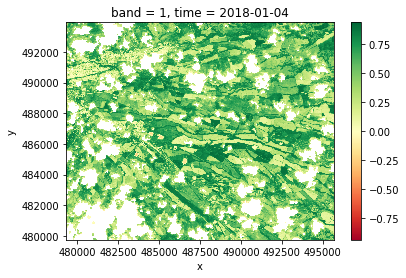

In [149]:
#optical_dtset['NDVI'].where(optical_dtset.mask).plot(cmap='RdYlGn')

av_dates = optical_dtset.coords['time'].data.tolist()
date = av_dates[1]

optical_dtset['NDVI'].sel(time=date).where(optical_dtset.mask.sel(time=date)).plot(cmap='RdYlGn')

In [169]:
time_series = optical_dtset['NDVI'].isel(y=100, x=100)
time_series

<xarray.DataArray 'NDVI' (time: 18)>
array([ 0.027758,  0.294613, -0.012117, -0.025431, -0.028922, -0.038853,
        0.827557, -0.026339,  0.051913,  0.012761,  0.817415,  0.183795,
       -0.018852,  0.763187, -0.021342,  0.602279,  0.154311, -0.015553],
      dtype=float32)
Coordinates:
    band     int64 1
    y        float64 4.929e+05
    x        float64 4.803e+05
  * time     (time) datetime64[ns] 2018-02-03 2018-01-04 2018-02-08 ...
    mask     (time) bool True False False False False False True False False ...
Attributes:
    crs:                       +init=epsg:32618
    header_offset:             0
    data_type:                 4
    nodatavals:                (nan,)
    file_type:                 ENVI Standard
    res:                       (10.0, 10.0)
    lines:                     1418
    transform:                 (479300.0, 10.0, -0.0, 493930.0, -0.0, -10.0)
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_18N",GEOGCS["GCS_

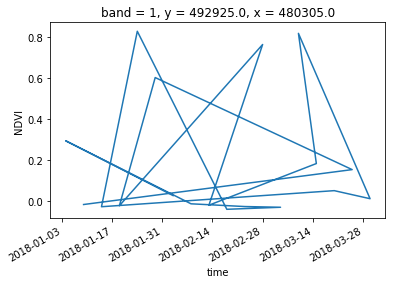

In [173]:
%matplotlib inline
#optical_dtset['NDVI'].isel(x=10, y=[19,21,22]).plot.line(x='time')
time_series.plot()

In [325]:
date = optical.getTempData('NDVI')
cloud = list(map(lambda x: x*100, optical.calcQualityPixels()))
for idx, val in enumerate(date):
        print('{}: {}'.format(val, cloud[idx]))

2018-02-03: 7.51802655893
2018-01-04: 66.0291283705
2018-02-08: 3.69029967055
2018-02-23: 20.2502794181
2018-03-05: 0.00413314940818
2018-02-18: 30.6056269385
2018-01-24: 99.355745336
2018-01-14: 32.000650971
2018-03-20: 15.0697210641
2018-03-30: 4.82769072332
2018-03-10: 99.5837574117
2018-03-15: 28.6427253987
2018-02-13: 0.0499422220156
2018-02-28: 76.6849041884
2018-01-19: 41.8479655433
2018-01-29: 68.4575258623
2018-03-25: 90.0032031908
2018-01-09: 0.0618250265641


In [326]:
imindex = 0

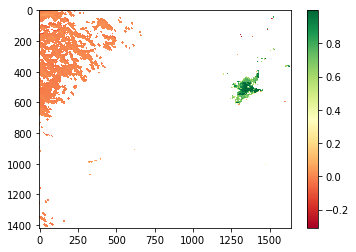

In [328]:
from matplotlib import pyplot
from rasterio.plot import show_hist
imindex = 0
#ndvi = optical.getMaskedBand('NDVI', tempid=imindex)

ndvi = optical_array

#print('{} at {}'.format(infor['band_name'], infor['image_date']))
pyplot.imshow(ndvi, cmap='RdYlGn')
pyplot.colorbar()
pyplot.show()

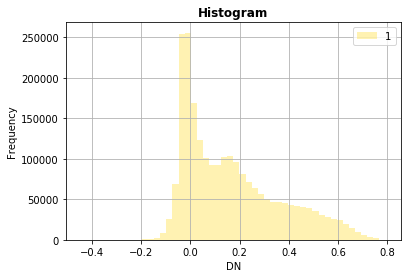

In [317]:
from rasterio.plot import show_hist

show_hist(ndvi, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')

In [9]:
## for mosaicing, a possible approach is gdalbuildvrt

# xarray

In [ ]:
## Check chunks meaning
#chunks = {'x': 5490, 'y': 5490, 'band': 1}
#da = xr.concat([xr.open_rasterio(f, chunks=chunks) for f in filenames], dim=time)
## To-do define type of dtype needed. Currently as dtype object
#da.to_netcdf('/home/azalazar/data/pre/stacks/Ibague.nc')
# Four axes, returned as a 2-d array

In [4]:
import math
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt

@xr.register_dataarray_accessor('eotemp')
class EOTempArray(object):
    
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        
    def plot_RGB(self):
        
        crs = ccrs.UTM('18N')
        av_dates = self._obj.coords['time'].data.tolist()
        
        plt.figure(figsize=(15,3*math.ceil(len(av_dates)/5.0)))
        try:
            rgb = self._obj.sel(band=['red', 'green', 'blue']).sortby('time')
        except:
            print('The EOTempArray does not contain rgb bands')
            return None
        for ix, date in enumerate(av_dates):
            ap = rgb.isel(time=ix)/10000
            ax = plt.subplot(math.ceil(len(av_dates)/5.0),5,1+ix, projection=crs)
            ap.plot.imshow(rgb='band', transform=crs)
        
        #plt.savefig("/home/azalazar/data/pre/stacks/rgb.pdf", dpi=300)
        plt.show()
        
#xr.register_accessor('spec', EOTempArray)

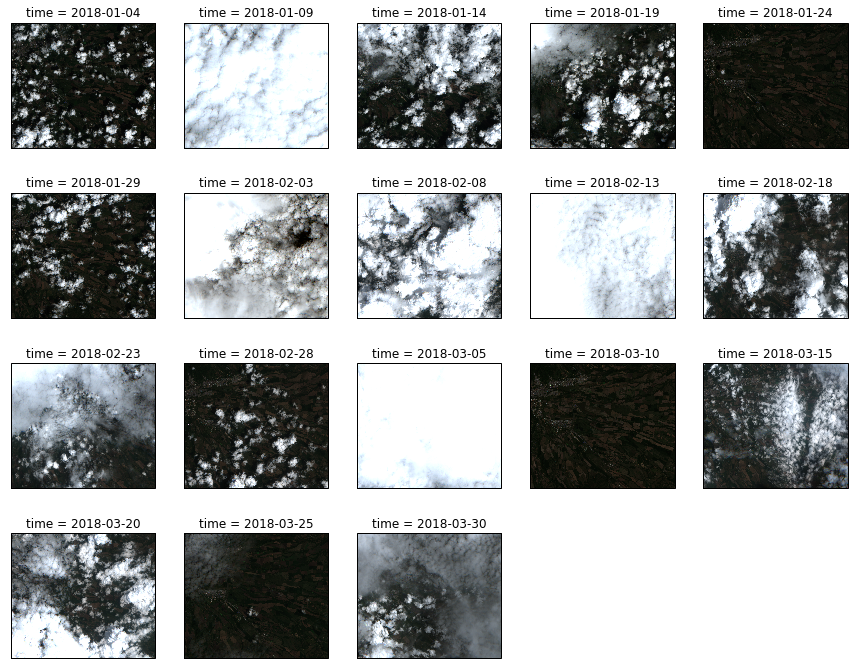

In [5]:
#import eotemparray
import xarray as xr

ds = optical_array

ds.eotemp.plot_RGB()  # calls the EOTempArray.plot_RGB method

In [6]:
radar_array.eotemp.plot_RGB()

The EOTempArray does not contain rgb bands


<Figure size 1080x432 with 0 Axes>

Use xarray object to report rgb images of eo_stack

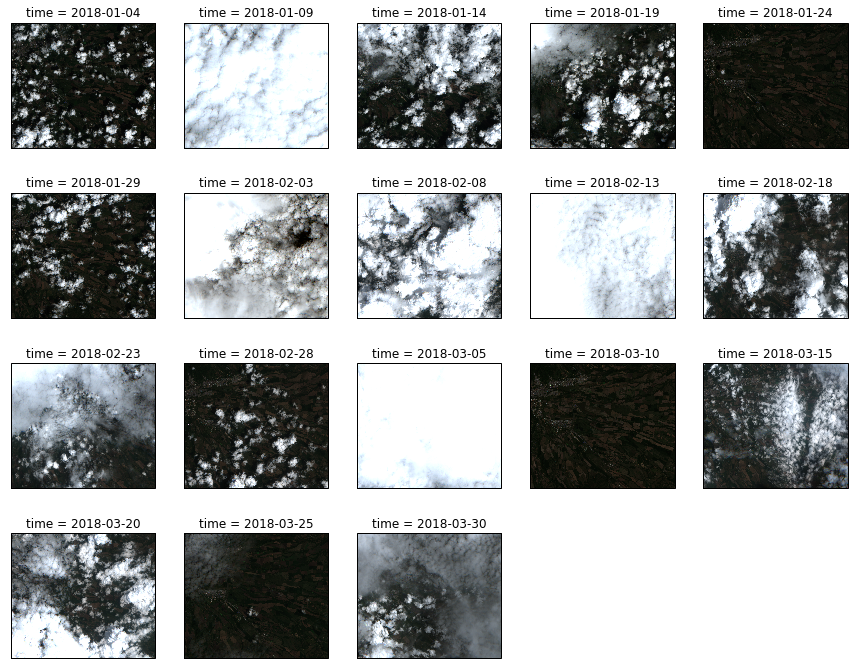

In [250]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt
import math

crs = ccrs.UTM('18N')

av_dates = optical_array.coords['time'].data.tolist()

plt.figure(figsize=(15,3*math.ceil(len(av_dates)/5.0)))

rgb = optical_array.sel(band=['red', 'green', 'blue']).sortby('time')

for ix, date in enumerate(av_dates):
    ap = rgb.isel(time=ix)/10000
    ax = plt.subplot(math.ceil(len(av_dates)/5.0),5,1+ix, projection=crs)
    ap.plot.imshow(rgb='band', transform=crs)

plt.savefig("/home/azalazar/data/pre/stacks/rgb.pdf", dpi=300)
plt.show()

In [264]:
optical_array.get_index('band').tolist()#strftime('%Y%m%d')#.argmin()

['CloudQA1',
 'CloudQA2',
 'green',
 'red',
 'swir2',
 'blue',
 'swir1',
 'NDVI',
 'LSWI',
 'nir']

In [201]:
ap

<xarray.DataArray (band: 3, time: 1, y: 1418, x: 1638)>
array([[[[0.0226, ..., 0.0741],
         ...,
         [0.06  , ..., 0.105 ]]],


       ...,


       [[[0.0182, ..., 0.0542],
         ...,
         [0.0426, ..., 0.0609]]]], dtype=float32)
Coordinates:
  * y        (y) float64 4.939e+05 4.939e+05 4.939e+05 4.939e+05 4.939e+05 ...
  * x        (x) float64 4.793e+05 4.793e+05 4.793e+05 4.793e+05 4.793e+05 ...
  * band     (band) object 'red' 'green' 'blue'
Dimensions without coordinates: time

# da.isel(band=0, time=slice(1, 4))

In [20]:
ds

<xarray.Dataset>
Dimensions:  (band: 1, time: 8, x: 1638, y: 1418)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.939e+05 4.939e+05 4.939e+05 4.939e+05 4.939e+05 ...
  * x        (x) float64 4.793e+05 4.793e+05 4.793e+05 4.793e+05 4.793e+05 ...
  * time     (time) datetime64[ns] 2018-01-16 2018-03-17 2018-03-29 ...
Data variables:
    ibague   (time, band, y, x) float32 0.0 -13.410422 -13.508159 -14.243623 ...

## Read S-2 example

In [16]:
sentinel2_dir = "D:/eo_data/Ibague/data/"

s2_ = eoTempStack(sentinel2_dir, 'D:/eo_data/Ibague/data/', 'S2')

S2 empty object initialized from D:/eo_data/Ibague/data/


In [11]:
s2_cloud_jp2 = "D:/eo_data/Ibague/data/S2A_MSIL2A_20171210T152631_N0206_R025_T18NVK_20171210T170838.SAFE/GRANULE/L2A_T18NVK_A012892_20171210T152634/QI_DATA/L2A_T18NVK_20171210T152631_CLD_60m.jp2"

#jp2s = ["/tmp/B01.jp2", "/tmp/B09.jp2", "/tmp/B10.jp2"]
arrs = []

with rasterio.open(s2_cloud_jp2) as f:
    arrs.append(f.read(1))

data = np.array(arrs, dtype=arrs[0].dtype)
data.shape


(1L, 1830L, 1830L)

In [12]:
data.dtype

dtype('uint8')

In [13]:
#### gdal reprojection

from osgeo import gdal, gdalconst

inputfile = #Path to input file
input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
inputProj = input.GetProjection()
inputTrans = input.GetGeoTransform()

referencefile = #Path to reference file
reference = gdal.Open(referencefile, gdalconst.GAReadOnly)
referenceProj = reference.GetProjection()
referenceTrans = reference.GetGeoTransform()
bandreference = reference.GetRasterBand(1)    
x = reference.RasterXSize 
y = reference.RasterYSize


outputfile = #Path to output file
driver= gdal.GetDriverByName('GTiff')
output = driver.Create(outputfile,x,y,1,bandreference.DataType)
output.SetGeoTransform(referenceTrans)
output.SetProjection(referenceProj)

gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

del output


In [14]:
#np.sum(bad_pixels)

#data

In [8]:
cloud_pixels_mask = data[0] > 9
cloud_cover = 1 - float(np.sum(cloud_pixels_mask)) / float(cloud_pixels_mask.size)

In [9]:
print cloud_cover

0.400828331691


In [102]:
from pprint import pprint
import rasterio
import numpy as np

path = radar_vv.stack_location
with rasterio.open(path) as src:
    array = src.read()

stats = []
i = 0
for band in array:
    ## First band has an error, is an empty band. From pre-processing in SNAP
    if i>0:
        stats.append({
            'min': band.min(),
            'mean': band.mean(),
            'median': np.median(band),
            'max': band.max()})
    i = i + 1

pprint(stats)

[{'max': 24.210934, 'mean': -8.817488, 'median': -8.756077, 'min': -24.761158},
 {'max': 23.672045, 'mean': -9.930789, 'median': -9.939377, 'min': -24.93194},
 {'max': 27.089819,
  'mean': -10.362202,
  'median': -10.394039,
  'min': -24.494234},
 {'max': 25.344566,
  'mean': -10.439367,
  'median': -10.537282,
  'min': -25.614614},
 {'max': 26.775578,
  'mean': -10.894947,
  'median': -11.015265,
  'min': -24.782732},
 {'max': 26.058949, 'mean': -9.558783, 'median': -9.597055, 'min': -24.783323},
 {'max': 26.774279, 'mean': -9.653883, 'median': -9.638872, 'min': -25.472023},
 {'max': 24.02989,
  'mean': -10.7197275,
  'median': -10.861368,
  'min': -25.61646},
 {'max': 24.58976, 'mean': -10.540494, 'median': -10.684661, 'min': -26.08511},
 {'max': 27.294153, 'mean': -9.116091, 'median': -9.133263, 'min': -24.8971},
 {'max': 24.374712, 'mean': -9.44039, 'median': -9.38195, 'min': -26.146618},
 {'max': 26.366924, 'mean': -9.546412, 'median': -9.493198, 'min': -25.246605},
 {'max': 23.46

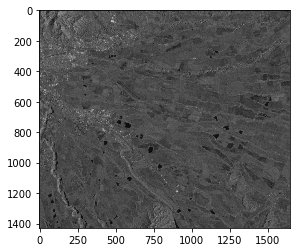

In [105]:
from rasterio.plot import show_hist
from matplotlib import pyplot

with rasterio.open(radar_vv.stack_location, 'r') as src:
    
    ## Histogram of values in a band
    
    #show_hist(src.read(5), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")
    
    ## 2-D plot of a band in raster
    pyplot.imshow(src.read(5), cmap='gist_gray')
    pyplot.show()

In [109]:
## Read raster bands directly to Numpy arrays.
with rasterio.open(radar_vv.stack_location) as src:
    r = src.read(2)

# Combine arrays in place. Expecting that the sum will
# temporarily exceed the 8-bit integer range, initialize it as
# a 64-bit float (the numpy default) array. Adding other
# arrays to it in-place converts those arrays "up" and
# preserves the type of the total array.
total = np.zeros(r.shape)
total = r
#for band in r, g, b:
#    total += band
#total /= 3

print(total)
print(total.mean())

[[-14.442285  -14.385927  -13.71005   ... -12.045914  -10.946045
   -9.73858  ]
 [-14.436144  -12.844044  -12.306133  ...  -9.964807   -8.826512
   -7.950416 ]
 [-13.300525  -11.922127  -10.508951  ...  -8.596113   -7.516251
   -6.773493 ]
 ...
 [ -8.759519   -8.851126   -8.346581  ...  -9.826294  -11.018783
  -11.769825 ]
 [ -8.965732   -9.055018   -8.149572  ...  -9.940113  -11.063294
  -11.890546 ]
 [ -8.544774   -8.4334135  -8.427343  ... -10.141455  -10.724653
  -10.985925 ]]
-8.817488


In [110]:
with rasterio.open(radar_vv.stack_location) as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)

(1643, 1428)
CRS({'init': u'epsg:4326'})
[-75.1865348950781, 8.98315284119523e-05, -0.0, 4.4686296672161, -0.0, -8.98315284119523e-05]
21
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21)


C:\Anaconda2\envs\spatial-analysis\lib\site-packages\IPython\core\interactiveshell.py:2882: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1282, 938)
CRS({'init': u'epsg:32618'})
[471315.0, 30.0, 0.0, 500055.0, 0.0, -30.0]
8
(1, 2, 3, 4, 5, 6, 7, 8)


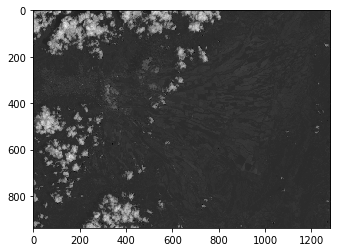

In [119]:
s1_loc = 'D:/eo_data/Ibague/LC08/pre/Ibague/LC08_L1TP_008057_20180301_20180308_01_T1.tif'

band_names = ["sr_band2", "sr_band3", "sr_band4", "sr_band5", "sr_band6", "sr_band7", "pixel_qa", "sr_aerosol"]

with rasterio.open(s1_loc) as src:
    
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    i = 0
    while i > 8:
        print(src.tags())
    
    pyplot.imshow(src.read(1), cmap='gist_gray')
    pyplot.show()